In [1]:
import json
import pandas as pd
import numpy as np

import re

from sqlalchemy import create_engine
import psycopg2

# from config import db_password

import time

In [2]:
#  Add the clean movie function that takes in the argument, "movie".
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles    

    # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')
    

    return movie

In [3]:
# 1 Add the function that takes in three arguments;
# Wikipedia data, Kaggle metadata, and MovieLens rating data (from Kaggle)

def extract_transform_load():
    # Read in the kaggle metadata and MovieLens ratings CSV files as Pandas DataFrames.
    kaggle_metadata = pd.read_csv(f'{file_dir}/movies_metadata.csv', low_memory=False)
    ratings = pd.read_csv(f'{file_dir}/ratings.csv')    

    # Open and read the Wikipedia data JSON file.
    with open(f'{file_dir}/wikipedia-movies.json', mode='r') as file:
        wiki_movies_raw = json.load(file)   
    
    # 3. Write a list comprehension to filter out TV shows.
    wiki_movies = [movie for movie in wiki_movies_raw
                   if('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie
                   and 'No. of episodes' not in movie]

    len(wiki_movies)

    # 4. Write a list comprehension to iterate through the cleaned wiki movies list
    # and call the clean_movie function on each movie.
    clean_movies = [clean_movie(movie) for movie in wiki_movies]

    # 5. Read in the cleaned movies list from Step 4 as a DataFrame.
    wiki_movies_df = pd.DataFrame(clean_movies)

    # 6. Write a try-except block to catch errors while extracting the IMDb ID using a regular expression string and
    #  dropping any imdb_id duplicates. If there is an error, capture and print the exception.
    
    try:
        wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
        wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)

    except Exception:
        print (f'{Exception} found while extracting imdb_link...skipping')
        
    #  7. Write a list comprehension to keep the columns that don't have null values from the wiki_movies_df DataFrame.
    wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
    wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

    # 8. Create a variable that will hold the non-null values from the “Box office” column.
    box_office = wiki_movies_df['Box office'].dropna()
    
    # 9. Convert the box office data created in Step 8 to string values using the lambda and join functions.
    box_office[box_office.map(lambda x: type(x) != str)]
    box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

    # 10. Write a regular expression to match the six elements of "form_one" of the box office data.
    form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
    
    # 11. Write a regular expression to match the three elements of "form_two" of the box office data.
    form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'
    
    box_office.str.extract(f'({form_one}|{form_two})')

    # 12. Add the parse_dollars function.
    def parse_dollars(s):
    # if s is not a string, return NaN
        if type(s) != str:
            return np.nan
    
        # if input is of the form $###.# million
        if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

            # remove dollar sign and " million"
            s = re.sub('\$|\s|[a-zA-Z]','', s)

            # convert to float and multiply by a million
            value = float(s) * 10**6

            # return value
            return value

        # if input is of the form $###.# billion
        elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

            # remove dollar sign and " billion"
            s = re.sub('\$|\s|[a-zA-Z]','', s)

            # convert to float and multiply by a billion
            value = float(s) * 10**9

            # return value
            return value

        # if input is of the form $###,###,###
        elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

            # remove dollar sign and commas
            s = re.sub('\$|,','', s)

            # convert to float
            value = float(s)

            # return value
            return value

        # otherwise, return NaN
        else:
            return np.nan

        
    # 13. Clean the box office column in the wiki_movies_df DataFrame.
    # Extract values from box_office using str.extract and apply parse_dollars to the first column in the dataframe
    wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
    
    # Drop Box office column b/c we do not need it
    wiki_movies_df.drop('Box office', axis=1, inplace=True)
    

    
    # 14. Clean the budget column in the wiki_movies_df DataFrame.
    budget = wiki_movies_df['Budget'].dropna()
    
    # convert any lists to strings
    budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
    
    # Remove any values between a dollar sign and a hyphen
    budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

    # Extract values from budget using str.extract and apply parse_dollars to the first column in the dataframe
    wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)


    
    
    # 15. Clean the release date column in the wiki_movies_df DataFrame.
    release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    
    # Set four variables to parse four different forms being captured
    date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
    date_form_two = r'\d{4}.[01]\d.[0123]\d'
    date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
    date_form_four = r'\d{4}'

    # Extract the dates
    release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)
    
    # Parse the dates using to_datetime() in Pandas
    wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)
    
    
    
    
    # 16. Clean the running time column in the wiki_movies_df DataFrame.
    running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
    
    running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False) != True]

    # Update to extract hour minute entries
    running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
    
    # Convert string to numeric values; set errors argument to "coerce" which will turn empty strings into NaN; use fillna to change
    # NaN's to 0
    running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
    
    # Convert hour capture groups and minute capture groups to minutes if pure minutes capture group is zero
    wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)
    
    # Drop "Running time" column from Data frame
    wiki_movies_df.drop('Running time', axis=1, inplace=True)
    
    
    # Return three variables. The first is the wiki_movies_df DataFrame
    # return wiki_movies_df, kaggle_metadata, ratings 

    
    
    # 2. Clean the Kaggle metadata.

    # Keep rows where adult column is false and then drop the adult column
    kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns') 

    # Create boolean column for 'video'
    kaggle_metadata['video'] == 'True'
    
    # Assign the column back to 'video'
    kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'
    
    # Convert 'budget', 'id', and 'popularity' columns using to_numeric() method; set errors= to 'raise' so we will now if any data
    # cannot be convered to numbers
    kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
    kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
    kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')
    
    # Convert 'release_date' to date time using to_datetime() function
    kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])
    
    
    # 3. Merged the two DataFrames into the movies DataFrame.
    # Merge to see which columns are redundant.  Use suffixes parameter to see what table each column belongs to
    movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])

    
    
    # 4. Drop unnecessary columns from the merged DataFrame.
    # What to do with competing column information?
# Competing data:
# Wiki                     Movielens                Resolution
#--------------------------------------------------------------------------
# title_wiki               title_kaggle          Drop Wikipedia
# running_time             runtime               Keep Kaggle; fill in zeros with Wikipedia data
# budget_wiki              budget_kaggle         Keep Kaggle; fill in zeros with Wikipedia data
# box_office               revenue               Keep Kaggle; fill in zeros with Wikipedia data
# release_date_wiki        release_date_kaggle   Drop Wikipedia
# Language                 original_language     Drop Wikipedia
# Production company(s)    production_companies  Drop Wikipedia
    
    # Review column data then drop columns

    # Look at titles from both sources
    movies_df[['title_wiki','title_kaggle']]
    
    # Look at rows where titles do not match
    movies_df[movies_df['title_wiki'] != movies_df['title_kaggle']][['title_wiki','title_kaggle']]
    
    # Show any rows where title_kaggle is empty
    movies_df[(movies_df['title_kaggle'] == '') | (movies_df['title_kaggle'].isnull())]
    
    # Check running_time vs runtime with scatter plot.  fill null values with zero
    movies_df.fillna(0).plot(x='running_time', y='runtime', kind='scatter')
    
    # Check budget_wiki and budget_kaggle with scatter plot like above
    movies_df.fillna(0).plot(x='budget_wiki',y='budget_kaggle', kind='scatter')
    
    # Check box_office and revenue with scatter plot like above
    movies_df.fillna(0).plot(x='box_office', y='revenue', kind='scatter')
    
    # Compare release_date_wiki vs release_date_kaggle with a line plot and change style- "." to plot method
    movies_df[['release_date_wiki','release_date_kaggle']].plot(x='release_date_wiki', y='release_date_kaggle', style='.')
    
    # Drop the row for this movie listing as outlier
    movies_df = movies_df.drop(movies_df[(movies_df['release_date_wiki'] > '1996-01-01') & (movies_df['release_date_kaggle'] < '1965-01-01')].index)

    # See if there are null values in wiki data for release_date
    movies_df[movies_df['release_date_wiki'].isnull()]
    
    # See if there are null values in kaggle data for release_date
    movies_df[movies_df['release_date_kaggle'].isnull()]
    
    # Convert lists in Language to tuples so value_counts() method will work
    movies_df['Language'].apply(lambda x: tuple(x) if type(x) == list else x).value_counts(dropna=False)
    
    # Run value_counts on Kaggle data because there are no lists
    movies_df['original_language'].value_counts(dropna=False)
    
    # Compare production company(s) of wiki and production_companies of Kaggle
    movies_df[['Production company(s)','production_companies']]
 


    # Drop title_wiki, release_date_wiki, Language, and Production company(s) as per table above
    movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)
    

    
    
    # 5. Add in the function to fill in the missing Kaggle data.
    def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
        df[kaggle_column] = df.apply(
            lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
            , axis=1)
        df.drop(columns=wiki_column, inplace=True)

    # 6. Call the function in Step 5 with the DataFrame and columns as the arguments.
    # Run the function for the three remaining column pairs listed above
    fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
    fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
    fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')
    movies_df

    # 7. Filter the movies DataFrame for specific columns.
    movies_df['video'].value_counts(dropna=False)

    # Reorder columns
    movies_df = movies_df.loc[:, ['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
                       'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
                       'genres','original_language','overview','spoken_languages','Country',
                       'production_companies','production_countries','Distributor',
                       'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writer(s)','Composer(s)','Based on'
                      ]]
    
    # 8. Rename the columns in the movies DataFrame.
    movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Writer(s)':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)

    
    # 9. Transform and merge the ratings DataFrame.
    # Check ratings data with info() method and set null_counts to True b/c it has so many rows
    ratings.info(null_counts=True)
    
    # Convert 'ratings' to timestamp
    pd.to_datetime(ratings['timestamp'], unit='s')
    
    # Assign output to 'timestamp' column
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
    
    # Include ratings data; Count how many times a movie received a given rating; use groupby()
    rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count()
    
    # Rename "userid" column to "count" and pivot data so movieId is the index and columns are rating values; rows will be counts
    rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')
    
    # Rename columns to they are easier to understand; prepend 'rating_' to each column
    rating_counts.columns = ['rating_' + str(col) for col in rating_counts.columns]
    
    # Left merge ratings_counts onto movies_df and create a new DF
    movies_with_ratings_df = pd.merge(movies_df, rating_counts, left_on='kaggle_id', right_index=True, how='left')
    
    # Because not every movie got a rating at each level, fill missing values with 0-zero
    movies_with_ratings_df[rating_counts.columns] = movies_with_ratings_df[rating_counts.columns].fillna(0)



    
    return wiki_movies_df, movies_with_ratings_df, movies_df


In [4]:
# 10. Create the path to your file directory and variables for the three files.
file_dir = 'C://Users/Dr. Carter/Class/Movies_ETL_1'
# The Wikipedia data
wiki_file = f'{file_dir}/wikipedia-movies.json'
# The Kaggle metadata
kaggle_file = f'{file_dir}/movies_metadata.csv'
# The MovieLens rating data.
ratings_file = f'{file_dir}/ratings.csv'

C:\Users\Dr. Carter\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:305: FutureWarning: null_counts is deprecated. Use show_counts instead


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


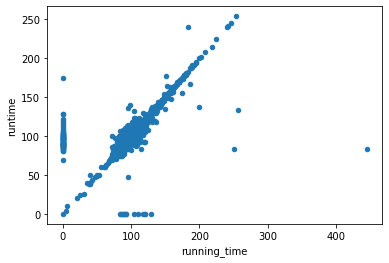

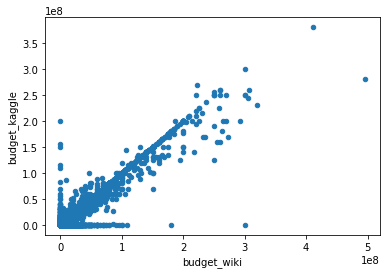

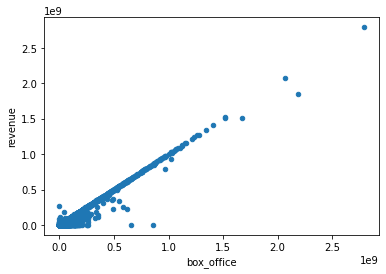

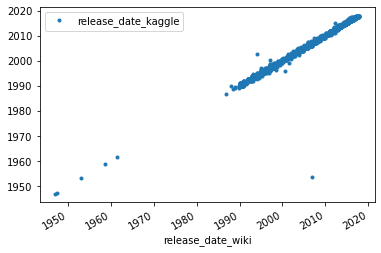

In [5]:
# 11. Set the three variables equal to the function created in D1.
wiki_file, kaggle_file, ratings_file = extract_transform_load()

In [6]:
# 12. Set the DataFrames from the return statement equal to the file names in Step 11. 
wiki_movies_df = wiki_file
movies_with_ratings_df = kaggle_file
movies_df = ratings_file

In [7]:
# 13. Check the wiki_movies_df DataFrame. 
wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Cinematography,Release date,Country,Language,...,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office,budget,release_date,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",United States,English,...,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,21400000.0,20000000.0,1990-07-11,102.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",United States,English,...,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,2700000.0,6000000.0,1990-05-17,114.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",United States,"[English, Lao]",...,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005,57718089.0,35000000.0,1990-08-10,113.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",United States,English,...,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012,7331647.0,12000000.0,1990-12-25,106.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",US,English,...,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018,6939946.0,25000000.0,1990-12-19,95.0


In [8]:
# 14. Check the movies_with_ratings_df DataFrame.
movies_with_ratings_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,rating_0.5,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5.0
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.0,49000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.0,6000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.0,35000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.0,12000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.0,25000000.0,...,3.0,0.0,3.0,2.0,5.0,26.0,37.0,46.0,16.0,11.0


In [9]:
# 15. Check the movies_df DataFrame. 
movies_df.head()

,imdb_id,kaggle_id,title,original_title,tagline,belongs_to_collection,wikipedia_url,imdb_link,runtime,budget,...,production_countries,distributor,producers,director,starring,cinematography,editors,writers,composers,based_on
0,tt0098987,9548,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane,Kojak. Columbo. Dirty Harry. Wimps.,NaN,https://en.wikipedia.org/wiki/The_Adventures_o...,https://www.imdb.com/title/tt0098987/,104.0,49000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",20th Century Fox,"[Steve Perry, Joel Silver]",Renny Harlin,"[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,Michael Tronick,"[David Arnott, James Cappe]","[Cliff Eidelman, Yello]","[Characters, by Rex Weiner]"
1,tt0098994,25501,"After Dark, My Sweet","After Dark, My Sweet",All they risked was everything.,NaN,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",https://www.imdb.com/title/tt0098994/,114.0,6000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",Avenue Pictures,"[Ric Kidney, Robert Redlin]",James Foley,"[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,Howard E. Smith,"[James Foley, Robert Redlin]",Maurice Jarre,"[the novel, After Dark, My Sweet, by, Jim Thom..."
2,tt0099005,11856,Air America,Air America,The few. The proud. The totally insane.,NaN,https://en.wikipedia.org/wiki/Air_America_(film),https://www.imdb.com/title/tt0099005/,112.0,35000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",TriStar Pictures,Daniel Melnick,Roger Spottiswoode,"[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[John Bloom, Lois Freeman-Fox]","[John Eskow, Richard Rush]",Charles Gross,"[Air America, by, Christopher Robbins]"
3,tt0099012,8217,Alice,Alice,NaN,NaN,https://en.wikipedia.org/wiki/Alice_(1990_film),https://www.imdb.com/title/tt0099012/,102.0,12000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",Orion Pictures,Robert Greenhut,Woody Allen,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,Susan E. Morse,Woody Allen,NaN,NaN
4,tt0099018,25943,Almost an Angel,Almost an Angel,Who does he think he is?,NaN,https://en.wikipedia.org/wiki/Almost_an_Angel,https://www.imdb.com/title/tt0099018/,95.0,25000000.0,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",Paramount Pictures,John Cornell,John Cornell,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,David Stiven,Paul Hogan,Maurice Jarre,NaN
